In [1]:
import os
import json
import gensim
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

c:\Users\sneha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_bva = "../data/annotations/20180415_bva.json"
PATH_cyber = "../data/annotations/20180415_cyber_crime.json"
PATH_intellectual = "../data/annotations/20180415_intellectual_property.json"
PATH_scotus = "../data/annotations/20180415_scotus.json"

train_PATHS = [PATH_bva, PATH_intellectual, PATH_scotus]
test_PATHS = [PATH_cyber]

In [3]:
dlimit_final = {}

In [4]:
def filter_delims(x):
    dataset = json.load(open(x, "r", encoding="utf8"))
    for doc in dataset:
        text = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
        dlimit = {}
        for pos, char in enumerate(text):
            if not char.isalnum():
                dlimit[char]=1
    return dlimit

dlimit_final.update(filter_delims(PATH_bva)) 
dlimit_final.update(filter_delims(PATH_intellectual)) 
dlimit_final.update(filter_delims(PATH_scotus)) 

In [5]:
window_size = 6

def dataset_gen(x, window_size=10):
    dataset = json.load(open(x, "r", encoding="utf8"))
    x = []
    y = []

    for doc in dataset:
        text = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
        ends = []

        for loc in dataset[doc]['annotations']:
            ends.append(loc['end'])

        for pos, char in enumerate(text):
            if char in dlimit_final.keys():
                right = text[pos+1:pos+window_size+1]
                left = text[pos-window_size-1:pos-1]

                if len(right) == 0:
                    right = "\n"+ " "*(window_size-1)

                # elif right.replace(".","")[0] == "\n":
                #     continue
                # elif right[0] == "\n":
                #     right = "\n"+ " "*(window_size-1)

                right = right + " "*(window_size-len(right))
                left = " "*(window_size-len(left)) + left

                x.append([left,char, right])

                if pos+1 in ends:
                    y.append(1) # setence eneded if 1
    
                else:
                    y.append(0) 

    return x, y

test_x,test_y = dataset_gen(test_PATHS[0], window_size=window_size)

train_x, train_y = [], []

for paths in train_PATHS:
    x,y = dataset_gen(paths, window_size=window_size)
    train_x = train_x + x
    train_y = train_y + y

print(len(train_x), len(test_x))

468047 162794


In [6]:
for i,j in zip(test_x, test_y):
    if j == 1:
        print(i)

['r. 200', ')', '\nCourt']
['4 (200', ')', '\nUNITE']
['pellan', '.', '\n\nNo. ']
['7-5025', '.', '\nUnite']
['Circui', '.', '\n\nArgu']
['0, 200', '.', '\nFiled']
['8, 200', '.', '\n*1155']
['pellan', '.', '\n\nAlex']
['ppelle', '.', '\n\nBefo']
['t Judg', '.', '\n\nMILA']
['t Judg', ':', '\n\nDefe']
['9(a)(4', '.', ' Barsu']
['e leve', '.', ' Barsu']
[' Offic', '.', ' We af']
['nditio', '.', '\n\nFact']
['t card', '.', ' Barsu']
['d frau', '.', ' The i']
['e Agen', '.', ' Durin']
['t card', '.', ' Barsu']
['istere', '.', ' The A']
['rsumya', '.', ' He th']
['t card', '.', '\n\nThe ']
['number', '.', ' At a ']
['it car', '.', ' When ']
['skimme', '.', ' He al']
['al car', '.', ' He th']
['e Agen', '.', '\n\nBars']
[')(4).[', ']', ' Pursu']
['uipmen', '.', ' The a']
['uipmen', '.', ' The g']
['r lowe', '.', '\n\nU.S.']
['vel 12', '"', ' Secti']
[' level', '.', ' The P']
['l of 1', '.', ' Barsu']
['releas', ':', '\n\n3. T']
['ase:\n\n', '.', ' The d']
['legall', '.', ' The d']
[' Offic'

In [7]:
def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")


dataset = json.load(open(test_PATHS[0], "r", encoding="utf8"))

for doc in dataset:
    text = dataset[doc]['text']
    print(raw_str(text)[:1000])
    break
    

United States v. Barsumyan, 517 F.3d 1154 (9th Cir. 2008)\nCourt of Appeals for the Ninth Circuit\nFiled: February 28th, 2008\nPrecedential Status: Precedential\nCitations: 517 F.3d 1154\nDocket Number: 07-50251\nAuthor: Joseph Jerome Farris\n\n517 F.3d 1154 (2008)\nUNITED STATES of America, Plaintiff-Appellee,\nv.\nAram BARSUMYAN, aka Seal A(1), Defendant-Appellant.\n\nNo. 07-50251.\nUnited States Court of Appeals, Ninth Circuit.\n\nArgued and Submitted January 10, 2008.\nFiled February 28, 2008.\n*1155 Davina T. Chen, Deputy Federal Public Defender, Los Angeles, CA, for the defendant-appellant.\n\nAlexander A. Bustamante and Anne Voights, Assistant United States Attorneys, Major Frauds Section, Los Angeles, CA, for the plaintiff-appellee.\n\nBefore: JEROME FARRIS and MILAN D. SMITH, JR., Circuit Judges, and H. RUSSEL HOLLAND,[*] District Judge.\n\nMILAN D. SMITH, JR., Circuit Judge:\n\nDefendant-Appellant Aram Barsumyan appeals the sentence imposed by the district court following his

In [8]:
i=0
for j in train_y:
    if j==1:
        i+=1

print(i, len(train_y)-i, 100*(i/len(train_y)))

15608 452439 3.3347078391699982


In [9]:
import string

characters = list(' '+string.printable.replace(" ",""))
characters.append('UNK')

characters = {x:i for i, x in enumerate(characters)}

print(len(characters))

characters

101


{' ': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10,
 'a': 11,
 'b': 12,
 'c': 13,
 'd': 14,
 'e': 15,
 'f': 16,
 'g': 17,
 'h': 18,
 'i': 19,
 'j': 20,
 'k': 21,
 'l': 22,
 'm': 23,
 'n': 24,
 'o': 25,
 'p': 26,
 'q': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'x': 34,
 'y': 35,
 'z': 36,
 'A': 37,
 'B': 38,
 'C': 39,
 'D': 40,
 'E': 41,
 'F': 42,
 'G': 43,
 'H': 44,
 'I': 45,
 'J': 46,
 'K': 47,
 'L': 48,
 'M': 49,
 'N': 50,
 'O': 51,
 'P': 52,
 'Q': 53,
 'R': 54,
 'S': 55,
 'T': 56,
 'U': 57,
 'V': 58,
 'W': 59,
 'X': 60,
 'Y': 61,
 'Z': 62,
 '!': 63,
 '"': 64,
 '#': 65,
 '$': 66,
 '%': 67,
 '&': 68,
 "'": 69,
 '(': 70,
 ')': 71,
 '*': 72,
 '+': 73,
 ',': 74,
 '-': 75,
 '.': 76,
 '/': 77,
 ':': 78,
 ';': 79,
 '<': 80,
 '=': 81,
 '>': 82,
 '?': 83,
 '@': 84,
 '[': 85,
 '\\': 86,
 ']': 87,
 '^': 88,
 '_': 89,
 '`': 90,
 '{': 91,
 '|': 92,
 '}': 93,
 '~': 94,
 '\t': 95,
 '\n': 96,
 '\r': 97,
 '\x0b': 98,
 '\x0c': 99,


In [10]:
def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")


class SBD_dataset(Dataset):
    def __init__(self, x, y, char_dict):
        self.x = x
        self.y = y
        self.len = len(x)
        self.char_dict = char_dict

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x_ = ''.join(self.x[idx][0]) + ''.join(self.x[idx][1])+''.join(self.x[idx][2])
        
        x = []

        for i in x_:
            if i in self.char_dict:
                x.append(self.char_dict[i])

            else:
                x.append(self.char_dict['UNK'])

        # if len(x)!=20:
        #     print(self.x[idx])
        #     print(len(x))
        return torch.IntTensor(x), self.y[idx]


batch_size = 32


train_dataset = SBD_dataset(train_x[:-3000], torch.FloatTensor(train_y[:-3000]), characters)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

validation_dataset = SBD_dataset(train_x[-3000:], torch.FloatTensor(train_y[-3000:]), characters)
vailidation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = SBD_dataset(test_x, torch.FloatTensor(test_y), characters)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [11]:
class bigru_attn(nn.Module):
    def __init__(self,hidden_size,n_layer,vocab_size,embedding_size):
        super().__init__()
        self.n_layer = n_layer
        self.hidden_size = hidden_size

        self.embedding_layer = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.gru_layer = nn.GRU(embedding_size,int(hidden_size),n_layer,batch_first = True, bidirectional = True)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(2*hidden_size,1)

    def attention_net(self, bigru_output, final_state):
        hidden = final_state.view(-1, self.hidden_size * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(bigru_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(bigru_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self,x):
        x = self.embedding_layer(x)
        output, final_hidden_state = self.gru_layer(x)
        attn_output, attention = self.attention_net(output, final_hidden_state)
        x = self.dropout(attn_output)
        x = torch.sigmoid(self.out(x))

        return x

# model(torch.IntTensor(list(range(len(characters)))).reshape(1,-1))

lr = 0.001
epoch = 25

train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = vailidation_dataloader.__len__()
test_n_minibatches = test_dataloader.__len__()

device = "cuda"
model_name = "bigru_attn"
model = bigru_attn(256,1,len(characters), 128)

loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [12]:

def TF_PN(pred, target):
    x = [0,0,0,0] #TP, TN, FP, FN
    for i, j in zip(pred, target):
        i = round(i[0])
        j = int(j)
    
        if i == 0:
            if j == 0:
                x[1]+=1
            else:
                x[3]+=1

        else:
            if j == 0:
                x[2]+=1
            else:
                x[0]+=1


    return x

def accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def acc_recall_precision_f1(y_pred, y):
    i = TF_PN(y_pred, y)
    acc = accuracy(i)
    rec = recall(i)
    prec = precision(i)
    f1 = f1_score(i)
    specificity_ = specificity(i)

    return acc, rec, prec, f1, specificity_

In [13]:
import string

characters = list(' '+string.printable.replace(" ",""))
characters.append('UNK')

characters = {x:i for i, x in enumerate(characters)}


def BIL_model(model, text):
    text = text.replace("\r","\n").replace("\t","\n")

    x = []
    offsets = []
    
    for pos, char in enumerate(text):
        if char in dlimit_final.keys():
            right = text[pos+1:pos+window_size+1]
            left = text[pos-window_size-1:pos-1]
            if len(right) == 0:
                right = "\n"+ " "*(window_size-1)
            # elif right.replace(".","")[0] == "\n":
            #     continue
            # elif right[0] == "\n":
            #     right = "\n"+ " "*(window_size-1)
            right = right + " "*(window_size-len(right))
            left = " "*(window_size-len(left)) + left

            x.append([left,char, right])
            offsets.append(pos)


    inputs = []
    for i in x:
        temp = []
        x_ = ''.join(i[0]) + ''.join(i[1])+ ''.join(i[2])
        for i in x_:
            if i in characters:
                temp.append(characters[i])

            else:
                temp.append(characters['UNK'])
            
        inputs.append(np.asarray(temp))

    inputs = torch.IntTensor(np.asarray(inputs))

    pred = model(inputs)

    pred = pred.cpu().detach().numpy().tolist()
    pred_offsets = []

    for each_pred in pred:
        pred_offsets.append(round(each_pred[0]))

    output = []
    start = 0

    for i,j in zip(offsets, pred_offsets):
        if j == 1:
            output.append(text[start:i+1])
            start = i+1

    return output

def BIL_TF_PN(original, pred):
    original = original.replace("\n"," ").split()
    temp = pred.split()
    if len(temp) != 0:
        pred = temp
    # print(original)
    # print(pred)
    
    beggining = [0, 0, 0, 0] #TP, TN, FP, FN
    end = [0, 0, 0, 0]
    i_max = [0, 0, 0, 0]
    
    # Remove the if and else directly below. Then unindent the next if else statement
    if len(pred) == 0:
        print("NOT THERE")
        return
    
    if original[0] == pred[0]:
        beggining[0]+=1
        i_max[1]+=1
        end[1]+=1

    else:
        beggining[2]+=1
        i_max[3]+=1

    if original[-1] == pred[-1]:
        end[0]+=1
        i_max[1]+=1
        beggining[1]+=1

    else:
        end[2]+=1
        i_max[3]+=1

    change = False
    for pos in range(len(original)):
        # print(i_max[0], len(pred))
        if i_max[0] == len(pred):
            beggining[3] =0
            break
        
        if original[pos] != pred[0]:
            continue

        else:
            change = True
        
        i = [0, 0, 0, 0] #TP, TN, FP, FN
        temp_beg = beggining
        temp_end = end

        tip = len(original) if original < pred else pred

        for nth, (x, y) in enumerate(zip(range(pos, len(original)), range(len(pred)))):
            if original[x]==pred[y]:
                i[0]+=1
                temp_beg[1]+=1
                temp_end[1]+=1

            else:
                i[2]+=1
                temp_beg[1]+=1
                if nth!=tip:
                    temp_end[3]+=1


        if i[0]>i_max[0]:
            i_max = i
            if temp_beg[3]==0 and pos!=0:
                temp_beg[3]+=1

        elif i[0]==i_max[0] and (i[2] == 0) :
            i_max = i


            beggining = temp_beg
            end = temp_end
        

    if not change:
        i_max[2] = len(pred)-1

    return beggining, i_max, len(original), len(pred),  end


def raw_str(string):
    return string.replace("\n","\\n").replace("\r","\\r").replace("\t","\\t")

def check_range(pointer_start, pointer_end, ranges):
    intersection_dict = {}
    for i in ranges:
        if pointer_start>=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end>=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [i['end'] - i['start'], abs(i['start']-pointer_start)]
        
        if pointer_start>=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - pointer_start, abs(i['start']-pointer_start)]

        if pointer_start<=i['start'] and pointer_end<=i['end']:
            intersection_dict[str(i['start'])+'-'+str(i['end'])] = [pointer_end - i['start'], abs(i['start']-pointer_start)]

    max_intersection_key = None
    max_intersection_len = -1
    max_intersection_start_dist = 1000000
    
    for i in intersection_dict.keys():
        if intersection_dict[i][0]>max_intersection_len or (intersection_dict[i][0]==max_intersection_len and max_intersection_start_dist<intersection_dict[i][1]):
            max_intersection_len =  intersection_dict[i][0]
            max_intersection_key = i
            max_intersection_start_dist = intersection_dict[i][1]

    return max_intersection_key


def BIL_accuracy(x):
    if sum(x) == 0:
        return 0
    return (x[0]+x[1])/sum(x)

def BIL_recall(x):  #TP, TN, FP, FN
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[3])

def BIL_precision(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0]+x[2])

def BIL_f1_score(x):
    if x[0] == 0:
        return 0

    return x[0]/(x[0] + 0.5*(x[2]+x[3]))

def BIL_specificity(x):
    if x[1] == 0:
        return 0

    return x[1]/(x[1] + x[2])

def BIL_acc_recall_precision_f1(x):
    acc, rec, prec, f1, specificity_  = 0, 0, 0, 0, 0
    t = 0
    for i in x:
        acc = acc + BIL_accuracy(i)
        rec = rec + BIL_recall(i)
        prec = prec + BIL_precision(i)
        f1 = f1 + BIL_f1_score(i)
        specificity_ = specificity_ + BIL_specificity(i)
        

    return acc/len(x), rec/len(x), prec/len(x), f1/len(x), specificity_/len(x)


def BIL_results(model, timer=False):
    results = {}
    total_time = 0

    for path_ in test_PATHS:
        dataset = json.load(open(path_, "r", encoding="utf8"))
        results[path_] = []
        for doc in dataset:
            x = dataset[doc]['text'].replace("\r","\n").replace("\t","\n")
            y = []
            for sentence in dataset[doc]['annotations']:
                y.append(dataset[doc]['text'][sentence['start']:sentence['end']])

            start_time = time.time()
            pred = BIL_model(model, x)
            if timer:
                print("--- Model took %s seconds to predict ---" % (time.time() - start_time))
            
            total_time = total_time + (time.time() - start_time)
            # print(len(y), len(pred))


            pointer = 0
            mappings = []
            filtred_pred = []

            for pred_sentences in pred:
                maped = check_range(pointer, pointer+len(pred_sentences), dataset[doc]['annotations'])
                # if maped != None:
                #     print(raw_str(pred_sentences), raw_str(dataset['59bd4ac35116540935ee6851']['text'][int(maped.split('-')[0]):int(maped.split('-')[1])]), sep=" ====== ", end="\n\n")

                pointer+=len(pred_sentences)

                pred_sentences = pred_sentences.replace("\n"," ")
                # print(pred_sentences)
                if maped is not None :
                    mappings.append(dataset[doc]['text'][int(maped.split('-')[0]):int(maped.split('-')[1])])
                    filtred_pred.append(pred_sentences)
                    # print(len(pred_sentences))
                    # if len(pred_sentences) == 0:
                    #     print() 
                    results[path_].append(BIL_TF_PN(mappings[-1], filtred_pred[-1]))

    for paths in results:
        B = []
        I = []
        L = []

        for i in results[paths]:
            print(i)
            B.append(i[0])
            I.append(i[1])
            L.append(i[-1])


        print(f"B : {BIL_acc_recall_precision_f1(B)}")
        print(f"I : {BIL_acc_recall_precision_f1(I)}")
        print(f"L : {BIL_acc_recall_precision_f1(L)}\n")

        if timer:
             print(f"--- Model took a total of {total_time} seconds to predict all the documents ---")

        return BIL_acc_recall_precision_f1(B), BIL_acc_recall_precision_f1(I), BIL_acc_recall_precision_f1(L)


In [47]:
BIL_history.append(BIL_results(model))


([1, 11, 0, 0], [10, 0, 0, 0], 10, 10, [1, 11, 0, 0])
([1, 7, 0, 0], [7, 0, 0, 0], 7, 29, [0, 8, 1, 0])
([1, 13, 0, 0], [12, 0, 0, 0], 12, 12, [1, 13, 0, 0])
([1, 3, 0, 0], [2, 0, 0, 0], 2, 2, [1, 3, 0, 0])
([1, 8, 0, 0], [7, 0, 0, 0], 7, 7, [1, 8, 0, 0])
([1, 7, 0, 0], [6, 0, 0, 0], 6, 6, [1, 7, 0, 0])
([1, 5, 0, 0], [4, 0, 0, 0], 4, 4, [1, 5, 0, 0])
([0, 0, 1, 0], [0, 0, 0, 2], 1, 1, [0, 0, 1, 0])
([0, 1, 1, 0], [0, 1, 13, 1], 13, 14, [1, 0, 0, 0])
([1, 20, 0, 0], [19, 0, 0, 0], 19, 19, [1, 20, 0, 0])
([1, 17, 0, 0], [16, 0, 0, 0], 16, 16, [1, 17, 0, 0])
([1, 7, 0, 0], [6, 0, 0, 0], 6, 6, [1, 7, 0, 0])
([1, 29, 0, 0], [28, 0, 0, 0], 28, 28, [1, 29, 0, 0])
([1, 25, 0, 0], [24, 0, 0, 0], 24, 24, [1, 25, 0, 0])
([1, 49, 0, 0], [48, 0, 0, 0], 48, 48, [1, 49, 0, 0])
([1, 26, 0, 0], [25, 0, 0, 0], 25, 25, [1, 26, 0, 0])
([0, 1, 1, 0], [0, 1, 30, 1], 26, 31, [1, 0, 0, 0])
([1, 23, 0, 0], [22, 0, 0, 0], 22, 22, [1, 23, 0, 0])
([1, 23, 0, 0], [22, 0, 0, 0], 22, 22, [1, 23, 0, 0])
([1, 26, 0, 

In [14]:
import time
best_val_f1 = 0

best_val_acc = 0
best_val_prec = 0
best_val_recall = 0
best_val_spec = 0

log_idx = int(epoch / epoch)
total_t = 0
now = time.time()

# torch.cuda.synchronize()
for e in range(epoch):
    start_time = time.time()
    for batch_idx, (x, y) in enumerate(train_dataloader):
        now = time.time()
        model.train()  # Setting mode to train
        optimizer.zero_grad()
        x, y = x, y
        y_pred = model(x)
        # Calculating Loss
        loss = criterion(y_pred, y.view(-1,1))
        loss_history[0].append(float(loss.detach()))
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), epoch)
        optimizer.step()
        total_t = total_t + time.time() - now
        # Calaculating Accuracy
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
        accuracy_history[0].append(acc)
        recall_history[0].append(rec)
        prec_history[0].append(prec)
        f1_history[0].append(f1)
        specifity_history[0].append(specificity_)

    print(
        f"---------------------------------------EPOCH {e+1}-------------------------------------------"
    )
    print(
        f"TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}",
        end=" ",
    )
    print(
        f"TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN RECALL : {sum(recall_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN PRECISION : {sum(prec_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN F1 : {sum(f1_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}", end=" ",
    )
    print(
        f"TRAIN SPECIFITY : {sum(specifity_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}"
    )

    print("--- Trainining for this epoch took %s seconds ---" % (time.time() - start_time))




    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(vailidation_dataloader):
            model.eval()
            x, y = x.todevice(), y.todevice()
            y_pred = model(x)
            # Calculating Loss
            loss = criterion(y_pred, y.view(-1,1))
            loss_history[1].append(float(loss.detach()))

            # Calaculating Accuracy
            y_pred = y_pred.cpu().detach().numpy().tolist()
            y = y.cpu().detach().numpy().tolist()
            acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
            accuracy_history[1].append(acc)
            recall_history[1].append(rec)
            prec_history[1].append(prec)
            f1_history[1].append(f1)
            specifity_history[1].append(specificity_)

    # Saving the model progress
    if best_val_f1<sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches:

        best_val_f1 = sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        torch.save(model.state_dict(), f"saved_models/{model_name}")

        best_val_f1 = sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_prec = sum(prec_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_recall = sum(recall_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches
        best_val_spec = sum(specifity_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches

    # Log for e+1th epoch

    print(
        f"VALIDATION LOSS : {sum(loss_history[1][-1:-1*validation_n_minibatches-1:-1])/validation_n_minibatches}",
        end=" ",
    )
    print(
        f"VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION RECALL : {sum(recall_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION PRECISION : {sum(prec_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION F1 : {sum(f1_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}", end=" ",
    )
    print(
        f"VALIDATION SPECIFITY : {sum(specifity_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}"
    )

    print(
        "---------------------------------------------------------------------------------------------\n\n"
    )

---------------------------------------EPOCH 1-------------------------------------------
TRAIN LOSS : 0.024903706918554258 TRAIN ACCURACY : 0.9913939925681255 TRAIN RECALL : 0.5504764526234401 TRAIN PRECISION : 0.5590031195522541 TRAIN F1 : 0.5480636346862761 TRAIN SPECIFITY : 0.9970125255646277
--- Trainining for this epoch took 2415.2505741119385 seconds ---


AttributeError: 'Tensor' object has no attribute 'todevice'

United
OOOLALALAL
United
Court
OOOLALALAL
Court
UNITED
OOOLALALAL
UNITED
No.
OOOLALALAL
No.
United
OOOLALALAL
United
Argued
OOOLALALAL
Argued
Filed
OOOLALALAL
Filed
*1155
OOOLALALAL
*
Davina
OOOLALALAL
1155
Alexander
OOOLALALAL
Alexander
Before:
OOOLALALAL
Before:
MILAN
OOOLALALAL
MILAN
Defendant-Appellant
OOOLALALAL
Defendant-Appellant
Barsumyan
OOOLALALAL
Barsumyan
Barsumyan
OOOLALALAL
Barsumyan
We
OOOLALALAL
We
In
OOOLALALAL
Facts,
Barsumyan
OOOLALALAL
Barsumyan
The
OOOLALALAL
The
During
OOOLALALAL
During
Barsumyan
OOOLALALAL
Barsumyan
The
OOOLALALAL
The
He
OOOLALALAL
He
The
OOOLALALAL
The
At
OOOLALALAL
At
When
OOOLALALAL
When
He
OOOLALALAL
He
He
OOOLALALAL
He
Barsumyan
OOOLALALAL
Barsumyan
Pursuant
OOOLALALAL
Pursuant
The
OOOLALALAL
The
The
OOOLALALAL
The
U.S.S.G.
OOOLALALAL
U.S.S.G.
Section
OOOLALALAL
Section
The
OOOLALALAL
The
Barsumyan's
OOOLALALAL
Barsumyan's
3.
OOOLALALAL
3.
The
OOOLALALAL
The
The
OOOLALALAL
The
.
OOOLALALAL
.
.
OOOLALALAL
.
The
OOOLALALAL
The
The
OOOLALALAL
T

IndexError: list index out of range

In [26]:
print(best_val_f1, best_val_acc, best_val_prec, best_val_recall, best_val_spec)
print(total_t, total_t/epoch)

0.9718896276369042 0 0.9744488758483064 0.9709841848361769 0.9814454972730191
76.6915214061737 3.067660856246948


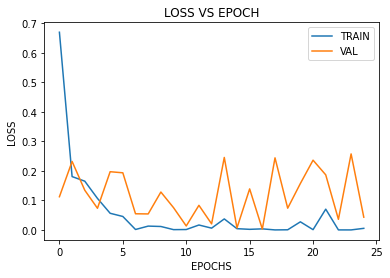

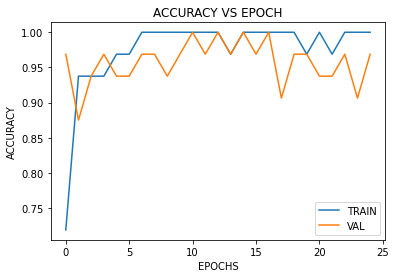

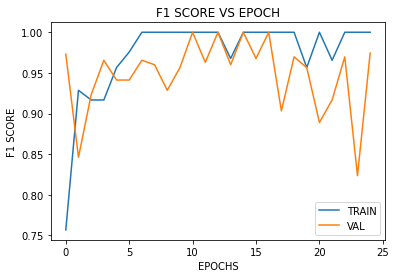

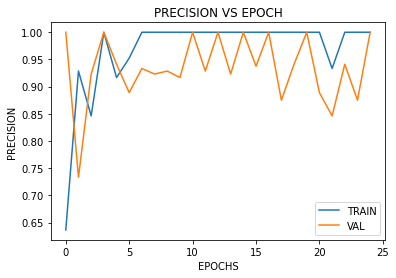

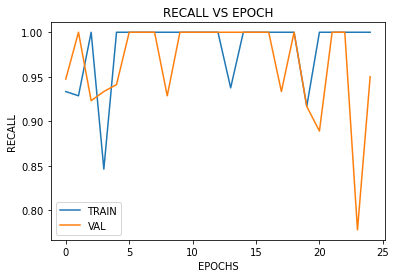

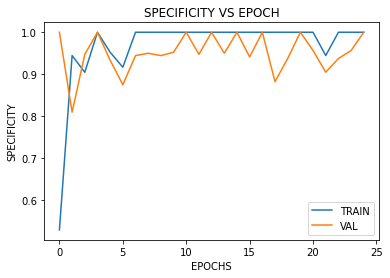

In [14]:
plt.plot(loss_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(loss_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.title("LOSS VS EPOCH")
plt.legend()
plt.savefig("loss_bigru_attn.pdf", format="pdf")
plt.show()


plt.plot(accuracy_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(accuracy_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.title("ACCURACY VS EPOCH")
plt.legend()
plt.savefig("acc_bigru_atnn.pdf", format="pdf")
plt.show()


plt.plot(f1_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(f1_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('F1 SCORE')
plt.title("F1 SCORE VS EPOCH")
plt.legend()
plt.savefig("f1_score_bigru_attn.pdf", format="pdf")
plt.show()


plt.plot(prec_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(prec_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('PRECISION')
plt.title("PRECISION VS EPOCH")
plt.legend()
plt.show()

plt.plot(recall_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(recall_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('RECALL')
plt.title("RECALL VS EPOCH")
plt.legend()
plt.show()

plt.plot(specifity_history[0][::train_n_minibatches], label="TRAIN")
plt.plot(specifity_history[1][::validation_n_minibatches], label="VAL")
plt.xlabel('EPOCHS')
plt.ylabel('SPECIFICITY')
plt.title("SPECIFICITY VS EPOCH")
plt.legend()
plt.show()



In [15]:
pickle.dump([loss_history, accuracy_history, prec_history, recall_history, f1_history, specifity_history, BIL_history] ,open(f"results/{model_name}_train_analysis.pkl", "wb"))

In [16]:
device = "cuda"
model = bigru_attn(256,1,len(characters), 128).to(device)
model.load_state_dict(torch.load(f"saved_models/{model_name}", map_location=device))


<All keys matched successfully>

In [17]:
loss_history = [[], []]
prec_history = [[], []]
recall_history = [[], []]
accuracy_history = [[], []]
f1_history = [[], []]
specifity_history = [[], []]
BIL_history = []


with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_dataloader):
        model.eval()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        # Calculating Loss
        loss = criterion(y_pred, y.view(-1,1))
        loss_history[1].append(float(loss.detach()))
        # Calaculating Accuracy
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        acc, rec, prec, f1, specificity_ = acc_recall_precision_f1(y_pred, y)
        accuracy_history[1].append(acc)
        recall_history[1].append(rec)
        prec_history[1].append(prec)
        f1_history[1].append(f1)
        specifity_history[1].append(specificity_)
# Saving the model progress

# Log for e+1th epoch
print(
    f"TEST LOSS : {sum(loss_history[1][-1:-1*test_n_minibatches-1:-1])/test_n_minibatches}",
    end=" ",
)
print(
    f"TEST ACCURACY : {sum(accuracy_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST RECALL : {sum(recall_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST PRECISION : {sum(prec_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST F1 : {sum(f1_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}", end=" ",
)
print(
    f"TEST SPECIFITY : {sum(specifity_history[1][-1:-test_n_minibatches-1:-1])/test_n_minibatches}"
)
print(
    "---------------------------------------------------------------------------------------------\n\n"
)

TEST LOSS : 0.14751990390464964 TEST ACCURACY : 0.9640281593406593 TEST RECALL : 0.9542543882000774 TEST PRECISION : 0.9611735667531267 TEST F1 : 0.9562685417175438 TEST SPECIFITY : 0.9708014413791781
---------------------------------------------------------------------------------------------




In [18]:
BIL_results(model, timer=True)

--- Model took 0.0049474239349365234 seconds to predict ---
--- Model took 0.007829904556274414 seconds to predict ---
--- Model took 0.00409698486328125 seconds to predict ---
--- Model took 0.008049964904785156 seconds to predict ---
--- Model took 0.005872964859008789 seconds to predict ---
--- Model took 0.008707523345947266 seconds to predict ---
--- Model took 0.00468754768371582 seconds to predict ---
--- Model took 0.010922431945800781 seconds to predict ---
--- Model took 0.003735780715942383 seconds to predict ---
--- Model took 0.005310535430908203 seconds to predict ---
--- Model took 0.006304264068603516 seconds to predict ---
--- Model took 0.004118204116821289 seconds to predict ---
--- Model took 0.005794525146484375 seconds to predict ---
--- Model took 0.010847091674804688 seconds to predict ---
--- Model took 0.002627134323120117 seconds to predict ---
--- Model took 0.004230499267578125 seconds to predict ---
--- Model took 0.0028014183044433594 seconds to predict -

((0.8876539812581683,
  0.802834008097166,
  0.802834008097166,
  0.802834008097166,
  0.8879079132649365),
 (0.8165870942793823,
  0.8165991902834008,
  0.8095558215875143,
  0.8106384605963503,
  0.007851306852362457),
 (0.9494470476123483,
  0.8503673737225838,
  0.8548582995951417,
  0.8506217763210686,
  0.8104498205056558))

In [19]:
model = model.to('cpu')

def BIL_model(model, text):
    device = 'cpu'
    text = text.replace("\r","\n").replace("\t","\n")

    x = []
    offsets = []
    
    for pos, char in enumerate(text):
        if char == ".":
            right = text[pos+1:pos+window_size+1]
            left = text[pos-window_size-1:pos-1]
            if len(right) == 0:
                right = "\n"+ " "*(window_size-1)
            # elif right.replace(".","")[0] == "\n":
            #     continue
            # elif right[0] == "\n":
            #     right = "\n"+ " "*(window_size-1)
            right = right + " "*(window_size-len(right))
            left = " "*(window_size-len(left)) + left

            x.append([left, right])
            offsets.append(pos)


    inputs = []
    for i in x:
        temp = []
        x_ = ''.join(i[0]) + ''.join(i[1])
        for i in x_:
            if i in characters:
                temp.append(characters[i])

            else:
                temp.append(characters['UNK'])
            
        inputs.append(np.asarray(temp))

    inputs = torch.IntTensor(np.asarray(inputs)).to(device)

    pred = model(inputs)

    pred = pred.cpu().detach().numpy().tolist()
    pred_offsets = []

    for each_pred in pred:
        pred_offsets.append(round(each_pred[0]))

    output = []
    start = 0

    for i,j in zip(offsets, pred_offsets):
        if j == 1:
            output.append(text[start:i+1])
            start = i+1

    return output


BIL_results(model, timer=True)


--- Model took 0.05303454399108887 seconds to predict ---
--- Model took 0.09690380096435547 seconds to predict ---
--- Model took 0.03974318504333496 seconds to predict ---
--- Model took 0.10068511962890625 seconds to predict ---
--- Model took 0.05965447425842285 seconds to predict ---
--- Model took 0.09380245208740234 seconds to predict ---
--- Model took 0.054062604904174805 seconds to predict ---
--- Model took 0.1147756576538086 seconds to predict ---
--- Model took 0.032422780990600586 seconds to predict ---
--- Model took 0.06079816818237305 seconds to predict ---
--- Model took 0.062484025955200195 seconds to predict ---
--- Model took 0.03562808036804199 seconds to predict ---
--- Model took 0.054720163345336914 seconds to predict ---
--- Model took 0.12383031845092773 seconds to predict ---
--- Model took 0.019313573837280273 seconds to predict ---
--- Model took 0.043004751205444336 seconds to predict ---
--- Model took 0.023782968521118164 seconds to predict ---
--- Mode

((0.8876539812581683,
  0.802834008097166,
  0.802834008097166,
  0.802834008097166,
  0.8879079132649365),
 (0.8165870942793823,
  0.8165991902834008,
  0.8095558215875143,
  0.8106384605963503,
  0.007851306852362457),
 (0.9494470476123483,
  0.8503673737225838,
  0.8548582995951417,
  0.8506217763210686,
  0.8104498205056558))

In [20]:
pickle.dump([loss_history, accuracy_history, prec_history, recall_history, f1_history, specifity_history, BIL_history] ,open(f"results/{model_name}_test_analysis.pkl", "wb"))